#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [76]:
# Testing if integration works

In [77]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [78]:
# file_name = '/media/drazen/HDD/PC/Faks/Diplomski/Prva/OSIRV/Projekt/datasets/multicoil_test/file_brain_AXT2_201_2010573.h5'
file_name = 'kspace.h5'
hf = h5py.File(file_name)

In [79]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['kspace']
Attrs: {}


In [80]:
print(hf['kspace'][()])

[[[[ 1.67055987e-06+2.9238872e-06j  0.00000000e+00+0.0000000e+00j
    -2.32225284e-06-8.7847002e-07j ...  0.00000000e+00+0.0000000e+00j
     0.00000000e+00+0.0000000e+00j  0.00000000e+00+0.0000000e+00j]
   [ 3.99746932e-06-1.2633391e-06j  0.00000000e+00+0.0000000e+00j
     1.79954804e-06-4.9560331e-06j ...  0.00000000e+00+0.0000000e+00j
     0.00000000e+00+0.0000000e+00j  0.00000000e+00+0.0000000e+00j]
   [-5.09200618e-07-5.7020225e-07j  0.00000000e+00+0.0000000e+00j
     3.08151357e-06-9.3574636e-07j ...  0.00000000e+00+0.0000000e+00j
     0.00000000e+00+0.0000000e+00j  0.00000000e+00+0.0000000e+00j]
   ...
   [ 5.02588227e-06-4.8696529e-06j  0.00000000e+00+0.0000000e+00j
    -1.54529698e-06+2.5536865e-06j ...  0.00000000e+00+0.0000000e+00j
     0.00000000e+00+0.0000000e+00j  0.00000000e+00+0.0000000e+00j]
   [-2.91876495e-06-1.0088552e-06j  0.00000000e+00+0.0000000e+00j
    -5.03310002e-06+1.8598512e-06j ...  0.00000000e+00+0.0000000e+00j
     0.00000000e+00+0.0000000e+00j  0.0000000

In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [81]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 20, 768, 396)


In [82]:
slice_kspace = volume_kspace[3] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [83]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [84]:
# plt.imshow(volume_kspace[0,:,:,0], cmap='gray')

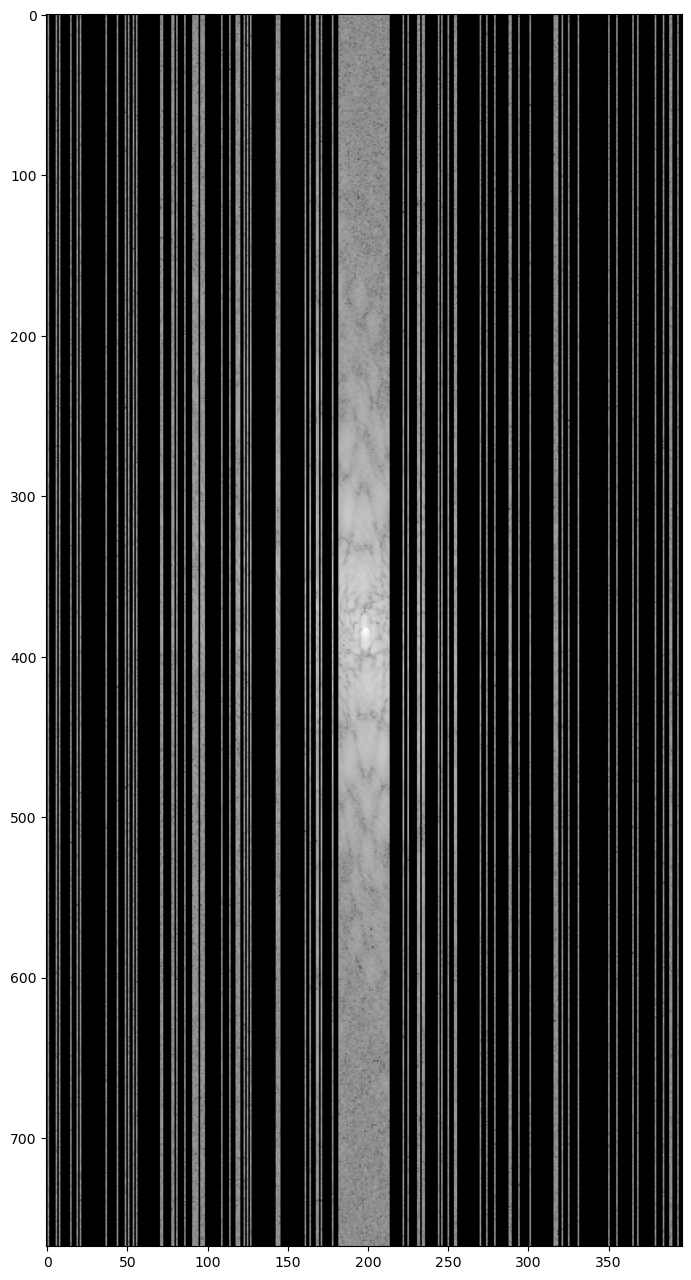

In [85]:
plt.rcParams['figure.figsize'] = [20, 16] # enlarge inline plots
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [15], cmap='gray')  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [86]:
import fastmri
from fastmri.data import transforms as T

In [87]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

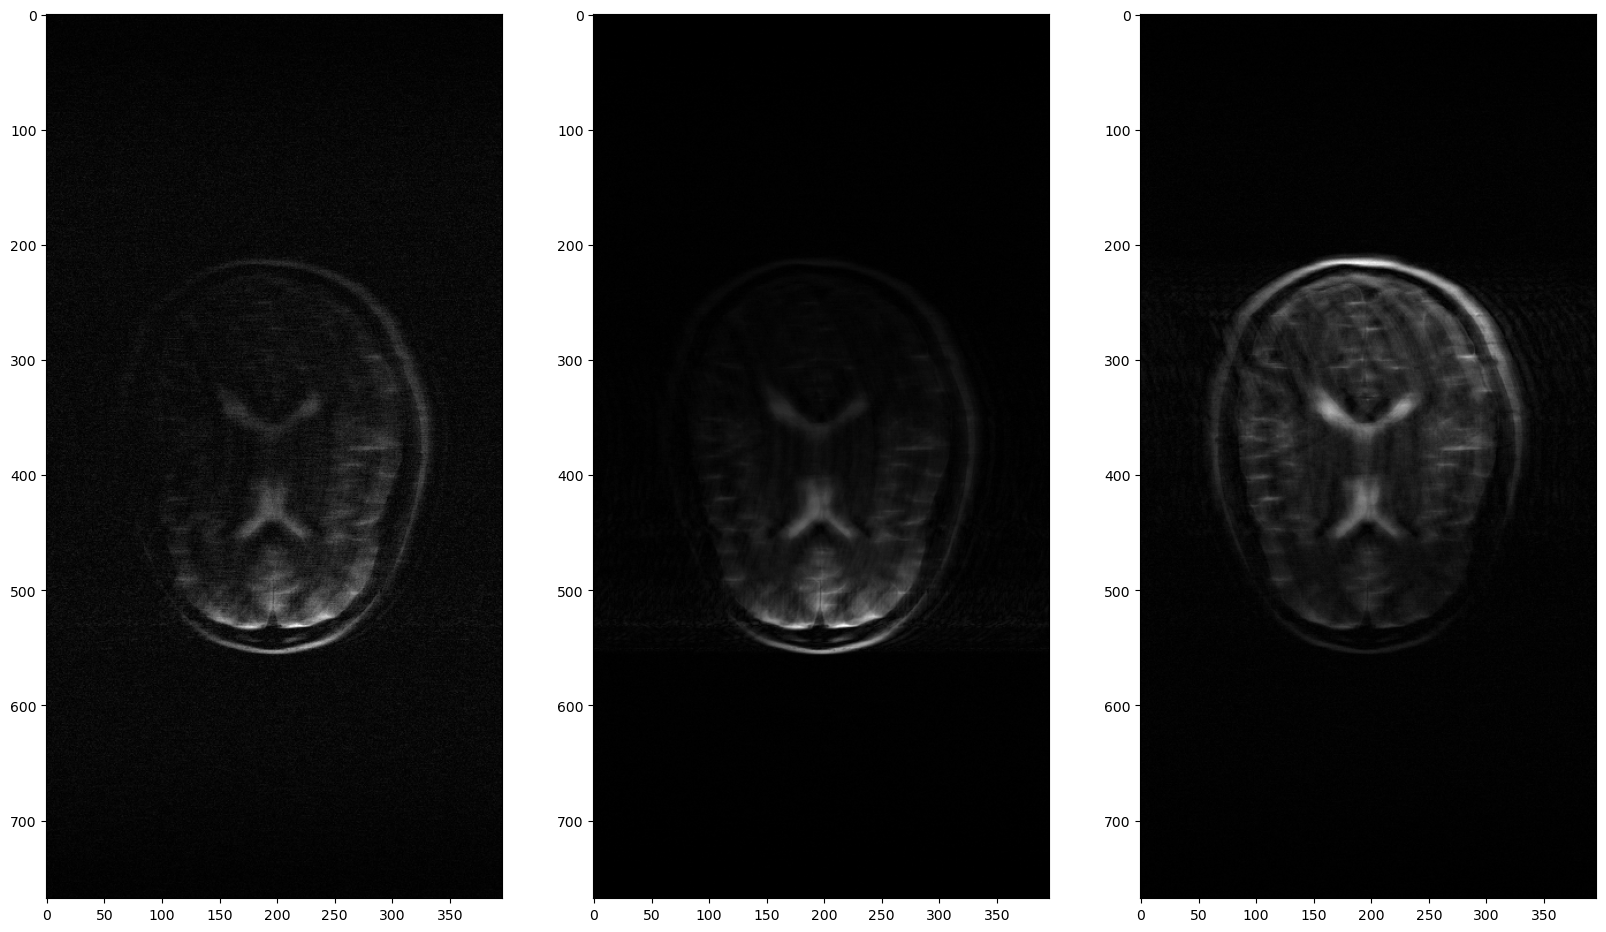

In [88]:
show_coils(slice_image_abs, [0, 15, 19], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [89]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

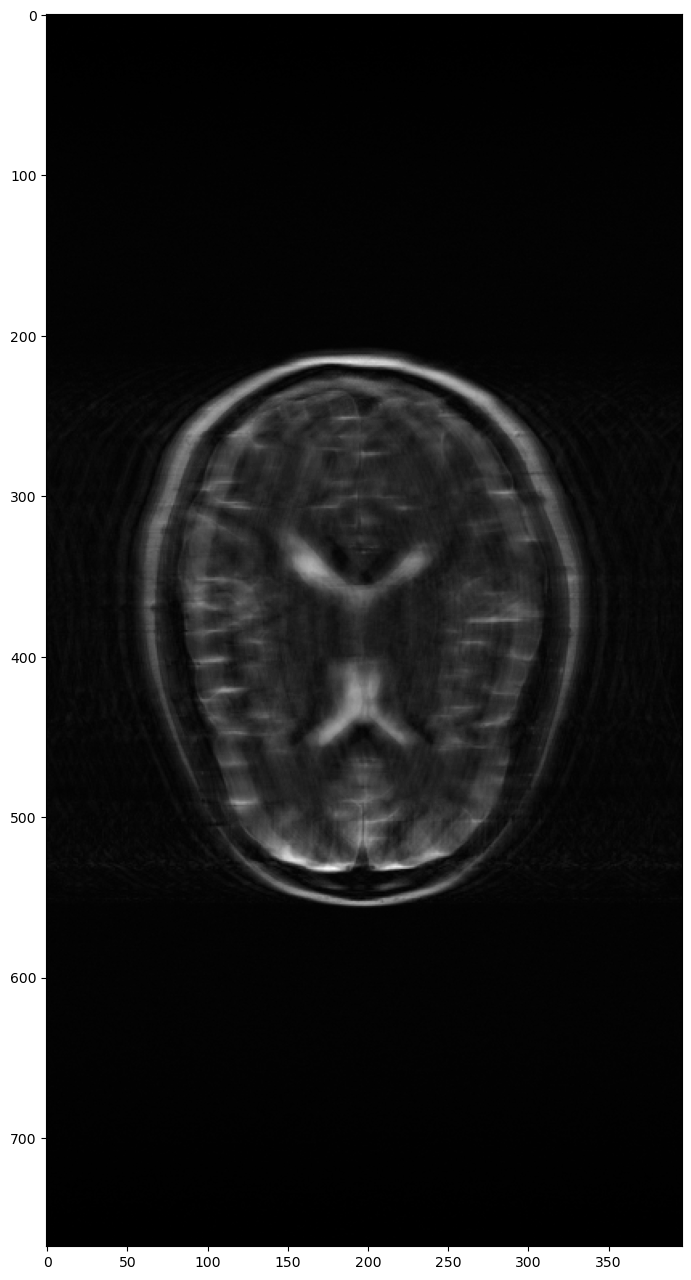

In [90]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [91]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [92]:


# `print(slice_kspace2[0,:,:,0].shape)`

In [93]:
masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

ValueError: too many values to unpack (expected 2)

Let's see what the subsampled image looks like:

In [ ]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

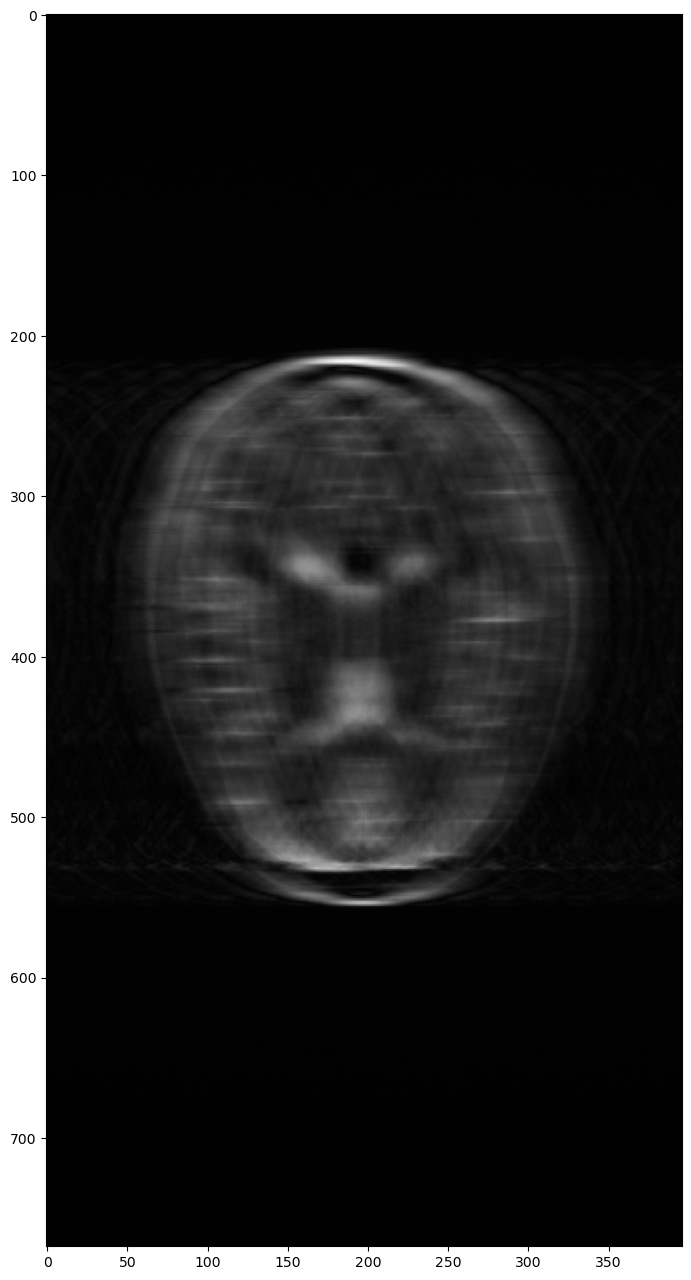

In [ ]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')